# Implementation of PLSI algorithm using Spark 

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import findspark
findspark.init("spark-2.2.3-bin-hadoop2.6")
import pyspark
from numpy import random
import math


In [2]:
from pyspark import sql

## 1. Prepare the environment

### Import the data

We will implement the PLSI algorithm on the Movielens dataset. To simplify our task, we will start by implementing the PLSI algorithm on a reduced version of the Movielens dataset ("ratings_short"), which contains 100 836 observations. 

In [3]:
ratings_data = pd.read_csv("ratings.csv")
ratings_data.head()

,user_id,user_username,movie_id,rating
0,2,William,1768,1
1,3,James,615,3
2,7,Joseph,82,3
3,7,Joseph,532,3
4,8,Thomas,698,3


**Description of the dataset :** 
- userId, to characterize the users 
- movieId, to characterize the movies
- rating : the rating of the user to the corresponding movie. Ratings are going from 1 to 5 but here we will only use the seen / not seen information to provide movie recommendations.  
- timestamp : we will not be using this column

More information about the movies are available in the "movies.csv" dataset : the movieId gives us access to the corresponding movie information such as the title and the genres. 

In [4]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.shape

(9742, 3)

### Create a Spark environment

In [6]:
sc = pyspark.SparkContext()

To be able to implement the PLSI algorithm in Spark, we will need to transform the dataset into an RDD, and then perform pyspark operations on it. 

In [7]:
rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

rdd.collect()[0:10]

['2,William,1768,1',
 '3,James,615,3',
 '7,Joseph,82,3',
 '7,Joseph,532,3',
 '8,Thomas,698,3',
 '10,Robert,1693,3',
 '11,Edward,615,1',
 '18,David,1,3',
 '18,David,28,3',
 '18,David,1596,5']

In [8]:
rdd.count()

295

## 2. Probabilistic Latent Semantic Indexing algorithm (PLSI)

The PLSI algorithm that we will implement here is based on Das description of the Google News recommendation system. The algorithm is based on the following model : 
- u (users) and s (movies) are random variables 
- The relationship between users and movies is learned by modeling the joint distribution of users and items as a mixture distribution 
- To capture this relationship, we introduce a hidden variable z (latent variable), that kind of represents user communities (same preferences) and movie communities (sames genres). 

All in all, we try to compute the following probability for each (user, movie) couple : p(s|u) = sum(p(s|z)p(z|u)), which is the probability for a given user to see a given movie. This is obtained by summing for each community the probability for a movie s to be seen given a community z times the probability to be in the community z given a user u. 

### Going through the algorithm : main steps

**INITIALISATION**

**E-STEP - Compute q( z | (u,s) ) : the probability that the (user, movie) couple belongs to the class z**
This step is first initialized at random :
- To each couple (u,s), assign each possible community 
- Ex with number of classes = 2 : the lines (Marie, Star Wars) and (Gaëlle, Matrix) will give (Marie, Star Wars, 1), (Marie, Star Wars, 2), (Gaëlle, Matrix, 1), (Gaëlle, Matrix, 2)
- To each line, assign a random probability. This random probability corresponds to q*( z | (u,s) ). For example if I have (Marie, Star Wars, 1, 0.3), then the probability that the couple (Marie, Star Wars) is in class 1 is 0.3. 

LogLik = 0

**ITERATION**

**M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) )**
- Compute p(s | z) :  sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z
- Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u

**E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u)**
- For each (u,s,z), compute p(s | z) * p(z | u)
- For each (u,s), compute ∑ p(s | z)* p(z | u) (summing over z)     ***(this corresponds to p(s|u))***
- For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u)             ***(this corresponds to the new q( z | (u,s) )***
	    
**Update LogLik** = sum( log( ∑ p(s | z) * p(z | u))) = sum( log (p(s | u))

**Iterate again until LogLik converges** : this means that it has reached its maximum and we have found the best estimation of p(z | u) and p(s | z).
	    
**We can now predict the probability that Gaëlle will watch Star Wars** :
p(Star Wars | Gaëlle) = p( 1 | Gaëlle) * p(Star Wars |1) + p(2 | Gaëlle) * p(Star Wars | 2)

### Implementing the algorithm 

Keep only (user, movie) information : 

In [9]:
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#### Initialisation of q : (first E-Step)

To each couple (u,s), assign each possible community z : 

In [10]:
nb_z = 3 #number of classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

In [11]:
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1]))
ordered_rdd.count()

882

To each line, assign a random probability :

In [12]:
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = (proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten()
random_p = list(random_p)

In [13]:
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 

In [420]:
q.count()

882

#### One iteration step 

M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) )

Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z

In [14]:
SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))

In [15]:
Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)

In [16]:
Z_probas = q.map(lambda x: (x[0][1], x[1]))

In [17]:
Nz = Z_probas.reduceByKey(lambda x,y: x+y)

In [18]:
Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))

In [19]:
Psz = Nsz.join(Nz)

In [20]:
Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1]))

Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u

In [21]:
ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))

In [22]:
Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)

In [23]:
U_probas = q.map(lambda x: (x[0][0][0], x[1]))

In [24]:
Nu = U_probas.reduceByKey(lambda x,y: x+y)

In [25]:
Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))

In [26]:
Pzu = Nzu.join(Nu)

In [27]:
Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1]))

E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u)

For each (u,s,z), compute p(s | z) * p(z | u)

In [28]:
q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))

In [29]:
q_int2 = q_int.join(Pzu)

In [30]:
q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))

In [31]:
PzuPsz = q_int3.join(Psz)

In [32]:
PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))

For each (u,s), compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u))

In [33]:
SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)

For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )

In [34]:
q1 = PzuPsz.join(SumPzuPsz)

In [35]:
q1 = q1.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))

Update LogLik = sum( log( ∑ p(s | z) * p(z | u))) = sum( log (p(s | u))

In [36]:
log = SumPzuPsz.map(lambda x : np.log(x[1]))
LogLik = log.reduce(lambda x,y : x+y)

End of the iteration step 

### Full Algorithm 

In [459]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 3 
nb_iterations = 5

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every three probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 

#Create an empty list to keep track of the LogLikelihood
LogLik = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz)
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu)
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu)
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz)
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print(L/N)
    LogLik.append(L/N)
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q1 = PzuPsz.join(SumPzuPsz)
    q1 = q1.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Update q
    q = q1

    

-1090.8013029750593
-1075.265821322012
-1049.138383517207


KeyboardInterrupt: 

## Plot the LogLikelihood

In [ ]:
fig = plt.figure()
fig.suptitle('Log-Likelihood', fontsize=20, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log-Likelihood')
ax.plot(LogLik)
plt.show()

## Build the Recommendation System

In [47]:
rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)
rdd = rdd.map(lambda line : line.split(','))
rdd = rdd.map(lambda line : (line[0], line[2]))

[('2', '1768'),
 ('3', '615'),
 ('7', '82'),
 ('7', '532'),
 ('8', '698'),
 ('10', '1693'),
 ('11', '615'),
 ('18', '1'),
 ('18', '28'),
 ('18', '1596')]

In [48]:
users = rdd.map(lambda x : x[0])
movies = rdd.map(lambda x : x[1])
classes = sc.parallelize(range(nb_z))

In [59]:
data = users.cartesian(movies)
data = data.cartesian(classes).map(lambda line : (line[0][0], line[0][1], line[1]))
data = data.distinct()

[('2', '641', 0),
 ('2', '457', 0),
 ('7', '82', 0),
 ('3', '698', 0),
 ('3', '1693', 0),
 ('7', '3252', 0),
 ('3', '737', 0),
 ('3', '496', 0),
 ('3', '797', 0),
 ('8', '1768', 0)]

In [60]:
ordered_data = data.sortBy(lambda x : (x[0], x[1], x[2]))

In [63]:
couples = ordered_data.map(lambda x : ((x[2], x[0]), (x[1], x[2])))

[((0, '10'), ('1', 0)),
 ((1, '10'), ('1', 1)),
 ((2, '10'), ('1', 2)),
 ((0, '10'), ('1096', 0)),
 ((1, '10'), ('1096', 1)),
 ((2, '10'), ('1096', 2)),
 ((0, '10'), ('1097', 0)),
 ((1, '10'), ('1097', 1)),
 ((2, '10'), ('1097', 2)),
 ((0, '10'), ('1118', 0))]

In [70]:
probas = couples.join(Pzu).map(lambda x : (x[1][0], (x[0], x[1][1])))

In [72]:
probas = probas.join(Psz)

In [85]:
Psu = probas.map(lambda x : (x[1][0][0][1], x[0][0], x[1][0][1]*x[1][1]))

In [87]:
probs = Psu.map(lambda x : x[2])

(array([2.1502e+04, 7.0810e+03, 4.6880e+03, 2.7280e+03, 1.2460e+03,
        4.1400e+02, 1.5800e+02, 8.3000e+01, 7.0000e+00, 1.0000e+00]),
 array([1.90878323e-06, 4.68686114e-03, 9.37181350e-03, 1.40567659e-02,
        1.87417182e-02, 2.34266706e-02, 2.81116229e-02, 3.27965753e-02,
        3.74815276e-02, 4.21664800e-02, 4.68514324e-02]),
 <a list of 10 Patch objects>)

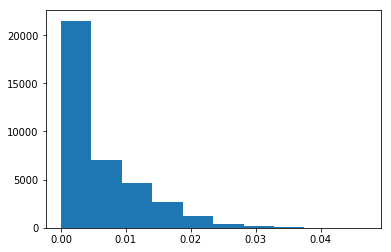

In [84]:
plt.hist(probs.collect())

Given the above plot, we decide to set the treshold at 0.01. If the probability of the movie given the user is higher than 0.01, we can advise this movie to the user. 

In [92]:
def prediction(rdd, threshold):
    return(rdd.map(lambda x : (x[0],x[1], x[2] >=threshold)))

In [93]:
result = prediction(Psu, 0.01)
result.collect()[0:10]

[('119', '805', False),
 ('244', '805', False),
 ('333', '805', False),
 ('519', '805', False),
 ('584', '805', False),
 ('705', '805', False),
 ('990', '805', False),
 ('186', '805', False),
 ('710', '805', False),
 ('175', '805', False)]